### código testeo de GPUs

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print('Available GPUs ')
get_available_gpus()

Available GPUs 


['/device:GPU:0']

### código para liberar GPUs

In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba'

### Probar cuda

In [4]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

## Creación de un clasificador de imágenes utilizando la API secuencial

- Utilizaremos el dataset Fashion MNIST, que sustiuye a MNIST.
- Tiene el formato de MNIST(70k imágenes en escala de grises de 28x28 íxeles, con 10 clases)
- Las imágenes representan artículos de moda en lugar de números manuscritos, así que las clases son más diferenets y el problema se vuelve mucho más difícil que MNIST.
    - MNIST: un modelo lineal sencillo llega a 92% de exactitud
    - Fashion MNIST: en este caso solo llega a 83% de exactitud

### Uso de Keras para cargar el conjunto de datos

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
fashion_mnist = keras.datasets.fashion_mnist

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

- Cada imagen se representa como una matrix de 28x28. 
- Las intensidades de los píxeles se representn como enteros (0 a 255) en vez de flotantes(0.0 a 255.0)

In [8]:
X_train_full.shape

(60000, 28, 28)

In [9]:
X_train_full.dtype

dtype('uint8')

- El conjunto está dividido en entrenamiento y pruebas, pero no hay validación, tendremos que crear uno.
- Dado que vamos a entrenar la red neuronal con descenso de gradiente, debemos escalar las características de entrada.
    - Escalaremos las instensidades de los píxeles hasta el 0-1 diviéndolas entre 255.0

In [10]:
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:] / 255.0

In [11]:
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Con MNIST, cuando la etiqueta es igual a 5, significa que la imagen representa el número 5 manuscrito. Sin embargo, con Fashion MNIST, necesitamos la lista de nombres de clase para saber con qué estamos tratando:

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coast", "Sandal", "Shirt", "Sneaker", "Bag","Ankle boot"]

In [13]:
class_names[y_train[0]]

'Coast'

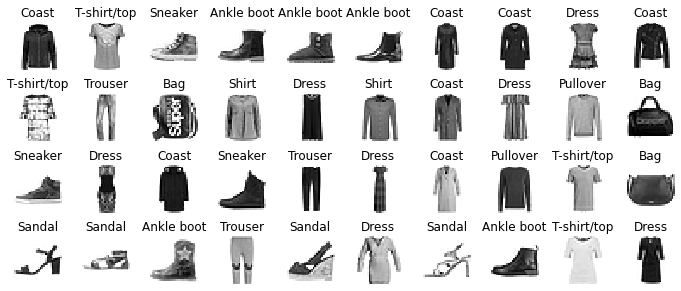

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

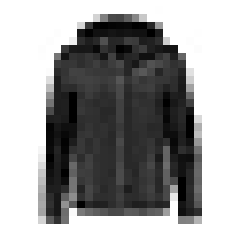

In [15]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

- Creación de un modelo Sequential. Es el tipo más sencillo de modelo de Keras para redes neuronales que consta solo de una única pila de capas conectadas secuencialmente. Es lo que se llama API secuencial

In [16]:
model = keras.models.Sequential()

- A continuación, construimos la primera capa y añadimos al modelo. Es una capa Flatten cuya función es convertir cada entrada de imagen en una matriz 1D: si recive datos de la entrada X, computa X.reshape(-1,1). Esta capa no tiene parámetros, está ahí solo para el preprocesamiento. Dado que se trata de la primera capa del modelo, deberías especificar input_shape, que no incluye el tamaño del lote, solo la forma de las instancias. Como alternativa, puedes añadir una capa keras.layers.InputLayer como primera cpa, configurando input_shape=[28,28]

In [17]:
model.add(keras.layers.Flatten(input_shape=[28,28]))

- Desués añadimos una capa Dense oculta con 300 neuronas, que utilizará la función de activación ReLU. Cada capa Dense administra su propia matriz de pesos, que contiene todos los pesos de conexión entre las neuronas y sus salidas. También gestiona un vector de términos de sesgo (uno por neurona).

In [18]:
model.add(keras.layers.Dense(300, activation='relu'))

- Luego añadimos una segunda capa Dense oculta con 100 neuronas, también con la función de activación ReLU

In [19]:
model.add(keras.layers.Dense(100, activation='relu'))

- Por último, añadimos una capa de salida Dense con 10 neuronas (una por clase), con la función de activación softmax(porque las clases son exclusivas)

In [20]:
model.add(keras.layers.Dense(10, activation="softmax"))

- En lugar de añadir las capas de una en una podemos pasar una lista de capas al crear el modelo Sequential:

In [21]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

- El método summary muestra un resumen de las capas y los parámetros.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


- Se puede conseguir una lista de capas del modelo:

In [23]:
model.layers

In [24]:
hidden1 = model.layers[1]

In [25]:
hidden1.name

'dense'

In [27]:
model.get_layer('dense') is hidden1

True

- Se puede acceder a todos los parámetros de una capa utilizando sus métodos get_wights() y set_weightd().
- Para una capa Dense, esto incluye tanto los pesos de conexión como los términos de sesgo:

In [28]:
weight, biases = hidden1.get_weights()

In [29]:
weight

array([[-0.05202346,  0.04776664,  0.05505526, ..., -0.05502917,
         0.02929763,  0.05636753],
       [-0.0395397 , -0.00291999, -0.02307609, ..., -0.01734661,
         0.02243754, -0.06655454],
       [-0.06023254, -0.0474097 , -0.0654242 , ..., -0.00779164,
        -0.0031507 , -0.06257842],
       ...,
       [ 0.04901219, -0.06292232,  0.06910484, ..., -0.03629965,
        -0.05887005, -0.03881078],
       [ 0.0322689 ,  0.04961727, -0.05702887, ..., -0.06480993,
         0.04597393,  0.01671734],
       [ 0.00805768,  0.02907991,  0.06341749, ..., -0.03094993,
         0.06393726, -0.05329397]], dtype=float32)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

- La forma de la matriz de pesos depende del número de entradas, por ello es recomendable especificar input_shpae para crear la pirmera capa de un modelo sequential, aunque sino se especifica Keras esperará hasta saber la forma de la entrada antes de crear el modelo.

### Compilación del modelo
- Después de crear el modelo hay que compilarlo con compile() para especificar la función de pérdida y el optimizador que se utilizará. De forma opcional, se puede especificar una lista de métricas adicionales que computar durante el entrenamiento y la evaluación:

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

- Usamos la pérdida sparse_categorical_crossentropy porque tenemos etiquetas en las que para cada instancia hay un solo índice de clase objetivo, de 0 a 9 en este caso y las clases son exclusivas, lo que denominamos etiquetas dispersas.

### Entrenamiento y evaluación del modelo

In [32]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 60us/sample - loss: 0.7338 - accuracy: 0.7573 - val_loss: 0.4996 - val_accuracy: 0.8352
Epoch 2/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4915 - accuracy: 0.8288 - val_loss: 0.4671 - val_accuracy: 0.8330
Epoch 3/30
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4443 - accuracy: 0.8443 - val_loss: 0.4398 - val_accuracy: 0.8516
Epoch 4/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4171 - accuracy: 0.8539 - val_loss: 0.3968 - val_accuracy: 0.8646
Epoch 5/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3950 - accuracy: 0.8602 - val_loss: 0.3789 - val_accuracy: 0.8706
Epoch 6/30
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3792 - accuracy: 0.8667 - val_loss: 0.3833 - val_accuracy: 0.8654
Epoch 7/30
55000/55000 [==============================] -

- Pasamos las características de entrada (X_train) y las clases objetivo (y_train), además del número de repeticiones para entrenar (si no lo hacemos, se establecería por defecto en 1, lo cual no sería lo bastante bueno para converger una buena solución).
- También pasamos un conjunto de validación.
- Keras medirá la pérdida y las métricas adicionales de este conjunto al final de cada repetición, lo cual es muy útil para ver si el modelo está rindiendo bien. Si el rendimiento del conjunto de entrenamiento es mucho mejor que el del conjunto de validación, es muy probable que el modelo esté sobreajustando el conjunto de entrenamiento.
- En cada repetición durante el entrenamiento, keras muestra el número de instancias  procesadas hasta el momento, el tiempo de entrenamiento medio por muestra y la pérdida y la exactitud (o cualquier otra métrica solicitada) para el conjunto de entrenamiento y para el de la validación. Veremos que la pérdida de entrenamiento ha bajado, lo cual es buena señal, y la exactitud de validación ha llegado al 88.18% tras 30 repeticiones. 

- Para obtener la curva de aprendizaje podemos crear un Dataframe:

In [33]:
import pandas as pd

In [34]:
import matplotlib.pyplot as plt

(0.0, 1.0)

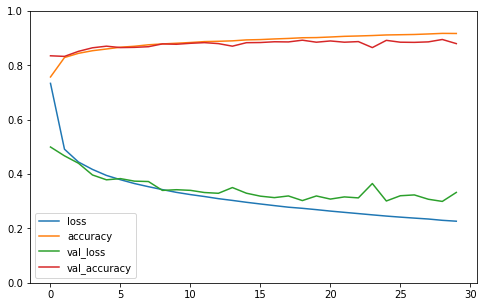

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid
plt.gca().set_ylim(0,1)

- Cuando estemos satisfechos con la exactitud de validación del modelo, debemos evaluarlo con el conjutno de prueba para estimar el error de generalización antes de implementar el modelo en producción. Puedes hacerlo fácilmente con el método evaluate()

In [36]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 43us/sample - loss: 66.9625 - accuracy: 0.8436


[66.96252846283913, 0.8436]

- Es habitual obtener un rendimiento logeramente inferior con el conjunto de pruebas que con el de validación, ya que los hiperparams están ajustados con el conjunto de validación.
- No hay que ajustar los hiperparams con el de prueba, porque al hacerlo la estimación del error de generalización será demasiado optimista.

### Uso del modelo para hacer predicciones

In [37]:
X_new = X_test[:3]

In [38]:
y_proba = model.predict(X_new)

In [39]:
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

- Para cada instancia, el modelo calcula una probabilidad por clase, desde la clase 0 hasta la 9

- Como nos sale que pueden ser varias opciones, como alternativa podemos utilizar predict_classes para obtener la más elevada:

In [40]:
y_pred = model.predict_classes(X_new)

In [41]:
y_pred

array([9, 2, 1], dtype=int64)

In [42]:
import numpy as np
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

- El clasificador ha clasificado correctamente las trés imágenes:

In [43]:
y_new = y_test[:3]

In [44]:
y_new

array([9, 2, 1], dtype=uint8)

## PMC de regresión con la API secuencial

- Vamos a cambiar al problema de la vivienda en California y usaremos redes neuronales de regresión.

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
housing = fetch_california_housing()

In [47]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [49]:
scaler = StandardScaler()

In [50]:
X_train = scaler.fit_transform(X_train)

In [51]:
X_valid = scaler.transform(X_valid)

In [52]:
X_test = scaler.transform(X_test)

- Utilizar la API secuencial para construir, entrenar,evaluar y usar una PMC de regresión para hacer predicciones es bastante similar a lo que hemos hecho para clasificación.
- Las diferencias principales son que la capa de salida tiene una sola neurona (porque solo queremos predecir un valor), no usa función de activación y la función de pérdida es el error cuadrático medio.
- Puesto que el conjunto de datos tiene bastante ruido, vamos a usar solo una capa oculta con menos neuronas que antes para evitar el sobreajuste:

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [54]:
model.compile(loss="mean_squared_error", optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.8805 - val_loss: 0.8859
Epoch 2/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6654 - val_loss: 0.4789
Epoch 3/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5087 - val_loss: 0.4667
Epoch 4/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4670 - val_loss: 0.4528
Epoch 5/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4528 - val_loss: 0.4418
Epoch 6/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4528 - val_loss: 0.4385
Epoch 7/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4377 - val_loss: 0.4274
Epoch 8/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4281 - val_loss: 0.4327
Epoch 9/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4233 - val_l

In [55]:
mse_test = model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 27us/sample - loss: 0.3916


In [56]:
X_new = X_test[:3]

In [57]:
y_pred = model.predict(X_new)

In [58]:
y_pred

array([[1.5362494],
       [3.0633569],
       [5.4332366]], dtype=float32)

- El API sequential es bastante sencilla pero a veces hay que construir redes neuronales con tipologías complejas o con múltiples entradas o salidas, para ello keras ofrece el API funcional.

## Creación de modelos complejos con la API funcional

- Un ejemplo de red neuronal no secuencial, es la red neuronal "ancha y profunda".
- Se introdujo en 2016 en un trabajo de Heng-Tze Cheng.
- Conecta todas o parte de las entradas directamente a la capa de salida.
- Esta arquitectura posibilita que la red neuronal aprenda dos patrones profundos (usando la ruta profunda) y las reglas sencillas (a través de la ruta corta)
    - PMC Normal: obliga a todos los daos a fluir por toda la pila de capas, de modo que patrones sencillos de datos pueden acabar distorsionados por esta secuencia de transformaciones.
    - PMC de ruta ancha y profunda permite que la red neuronal aprenda dos patrones profundos y reglas sencillas
- Construyamos una red neuronal así para el problema de la vivienda de California:

<div>
<img src="images/pmc_1.png" width="30%"/>
</div>

In [59]:
# se trata de una especificación del tipo de entrada que tendrá el modelo,
# incluidos su shape y dtype.
input_ = keras.layers.Input(shape=X_train.shape[1:]) 

In [60]:
# Creamos una capa Dense con 30 neuronas, con la función de activación ReLU
# En cuanto estñe creada, la llamamos como funciòn, pasándole la entrada, de ahi el nombre API funcional
# Solo le decimos a Keras como debería conectar las capas, todavía no se están procesando datos
hidden1 = keras.layers.Dense(30, activation='relu')(input_)

In [61]:
# Creamos una segunda capa oculta y volvemos a usarla como una función. 
# Le pasamos la salida de la primera capa oculta
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

In [62]:
# Creamos una capa Concatenate y la usamos de inmediato como un función,
# para concatenar la entrada y la salida de la segunda capa oculta.
concat = keras.layers.Concatenate()([input_,hidden2])

In [63]:
# Creamos la capa de salida
output = keras.layers.Dense(1)(concat)

In [64]:
# Creamos un model de keras, especificando las entradas y salidas para usar
model = keras.Model(inputs=[input_], outputs=[output])

In [65]:
# Compilamos el modelo
model.compile(loss="mean_squared_error", optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 72us/sample - loss: 2.6372 - val_loss: 0.9529
Epoch 2/20
11610/11610 [==============================] - 1s 54us/sample - loss: 5.6902 - val_loss: 1.1728
Epoch 3/20
11610/11610 [==============================] - 1s 53us/sample - loss: 5.7019 - val_loss: 1.4285
Epoch 4/20
11610/11610 [==============================] - 1s 53us/sample - loss: 1.2512 - val_loss: 2.8884
Epoch 5/20
11610/11610 [==============================] - 1s 53us/sample - loss: 8.9670 - val_loss: 49.7174
Epoch 6/20
11610/11610 [==============================] - 1s 53us/sample - loss: 491.8866 - val_loss: 53.6292
Epoch 7/20
11610/11610 [==============================] - 1s 53us/sample - loss: 511.5148 - val_loss: 70.6615
Epoch 8/20
11610/11610 [==============================] - 1s 54us/sample - loss: 843.5039 - val_loss: 97.4606
Epoch 9/20
11610/11610 [==============================] - 1s 53us/sample - loss: 732.

In [66]:
X_new = X_test[:3]

In [67]:
y_pred = model.predict(X_new)

In [68]:
y_pred

array([[8.057346 ],
       [4.27587  ],
       [1.8328173]], dtype=float32)

In [69]:
mse_test = model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 28us/sample - loss: 69.7860


### Enviar conjunto de características por ruta ancha y ruta profunda
- Suponiendo que queremos enviar un conjunto de características por la ruta ancha y otro por ruta profunda. En este caso queremos enviar cinco características por ruta ancha (de 0 a 4) y seis por ruta profunda (de 2 a 7):

<div>
<img src="images/pmc_2.png" width="30%"/>
</div>

In [73]:
input_A = keras.layers.Input(shape=[5], name='wide_input')

In [74]:
input_B = keras.layers.Input(shape=[6], name='deep_input')

In [75]:
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)

In [76]:
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

In [77]:
concat = keras.layers.concatenate([input_A, hidden2])

In [78]:
output = keras.layers.Dense(1, name='output')(concat)

In [79]:
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [80]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [81]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [82]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 74us/sample - loss: 1.7988 - val_loss: 0.9191
Epoch 2/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.7835 - val_loss: 0.6891
Epoch 3/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.6563 - val_loss: 0.6171
Epoch 4/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.6053 - val_loss: 0.5766
Epoch 5/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5727 - val_loss: 0.5495
Epoch 6/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5491 - val_loss: 0.5275
Epoch 7/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5312 - val_loss: 0.5113
Epoch 8/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5179 - val_loss: 0.4995
Epoch 9/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5075 - val_l

In [83]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

5160/5160 [==============================] - 0s 31us/sample - loss: 0.4516


In [84]:
y_pred = model.predict((X_new_A, X_new_B))

- Hay varios casos en los que interesa tener múltiples salidas:
    - La tarea puede requerirlo. Por ejemplo, puede que quereamos clasificar el objeto principal de una foto. Esto es una tarea de regresión (encontrar las coordenadas del centro del objeto además de su anchura y altura) y también de clasificación.
- Del mismo modo, puede que tengamos múltiples tareas independientes basadas en los mismos datos. Desde luego, podríamos entrenar una red neuronal por tarea, pero un muchos casos conseguiremos mejores resultados entrenando una sola red neuronal con una salida por tarea. Esto se debe a que la red neuronal aprende características de los datos que son útiles entre tareas. Por ejemplo, podríamos hacer clasificación multitarea con fotos de caras, usando una salida  para clasificar la expresión facial de la persona (sonrisa, sorpresa, etc) y otra para identificar si lleva gafas o no.
- Otro caso de uso es como técnica de regularización (es decir, una limitación de entrenamiento cuyo objetivo es reducir el sobreajuste y mejorar así la capacidad del modelo para generalizar). Por ejemplo, puede que nos interese añadir alguna salida auxiliar a la arquitectura de red neuronal para garantizar que la parte subyacente de la red aprende algo útil por su cuenta, sin depender del resto de la red.

<div>
<img src="images/pmc_3.png" width="30%"/>
</div>

- Añadir salidas adicionales es bastante facil: solo hay que conectarlas a las capas apropiadas y añadirlas a la lista de salidas del modelo. Por ejemplo, basada en la imagen anterior:

In [85]:
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

- Cada salida necesitará su función de pérdida. Así pues, al compilar el modelo, deberíamos pasaruna lista de pérdidas (si pasamos una sola pérdida, Keras asumirá que debe usar la misma pérdida para todas las salidas). Por defecto, Keras asumirá todas las pérdidas y simplemente las sumará para obtener la pérdida definitiva utilizada para el entrenamiento.
- Nos preocupamos mucho más por la salida principal que por la auxiliar ( ya que esta solo la usamos para la regularización), así que vamos a dar a la pérdida de la salida principal mucho más peso. Por suerte, es posible configurar todos los pesos de pérdida al compilar el modelo:

In [86]:
model.compile(loss=['mse','mse'], loss_weights=[0.9,0.1],optimizer='sgd')

- Cuando entrenemos el modelo, tenemos que suministrar etiquetas para cada salida. En este ejemplo, la salida principal y la auxiliar deberían intentar predecir lo mismo, así que usaremos las mismas etiqueta. Entonces, en vez de pasar y_train, tenemos que pasar (y_train, y_train) (y lo mismo se aplica a y_valid e y_test):

In [87]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 107us/sample - loss: 0.7855 - main_output_loss: 0.6789 - aux_output_loss: 1.7432 - val_loss: 0.5878 - val_main_output_loss: 0.5391 - val_aux_output_loss: 1.0250
Epoch 2/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.6709 - main_output_loss: 0.6384 - aux_output_loss: 0.9632 - val_loss: 0.5198 - val_main_output_loss: 0.4737 - val_aux_output_loss: 0.9340
Epoch 3/20
11610/11610 [==============================] - 1s 77us/sample - loss: 0.5080 - main_output_loss: 0.4662 - aux_output_loss: 0.8826 - val_loss: 0.4944 - val_main_output_loss: 0.4543 - val_aux_output_loss: 0.8553
Epoch 4/20
11610/11610 [==============================] - 1s 76us/sample - loss: 0.4865 - main_output_loss: 0.4505 - aux_output_loss: 0.8102 - val_loss: 0.4899 - val_main_output_loss: 0.4559 - val_aux_output_loss: 0.7957
Epoch 5/20
11610/11610 [==============================] - 1s 77us/

- Al evaluar el modelo, Keras devolverá la pérdida total, además de las pérdidas individuales:

In [89]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

5160/5160 [==============================] - 0s 43us/sample - loss: 0.3721 - main_output_loss: 0.3565 - aux_output_loss: 0.5119


- Del mismo modo, el método predict() devolverá predicciones para cada salida:

In [90]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

## Utilización de la API de subclasificación para crear modelos dinámicos

- Las API secuencial y funcional son declarativas
- El API de subclasificacion es buena para los casos en el que los modelos impliquen búcles, formas cambiantes, ramificación condicional y otros comportamientos dinámicos.
    - También si preferimos un modelo de programación más imperativo.
        - Subclasificamos la clase Model
        - Creamos las capas en el constructor
        - Usamos las capas para realizar cálculos que queramos en el método call()
        
- Ejemplo: 
    - Crear una instancia de la siguiente clase WideAndDeepModel da un modelo equivalente al que acavamos de crear con la API Funcional
        - Podemos compilarlo, evaluarlo y usarlo para hacer predicciones como hicimos anteriormente

In [91]:
class WideAndDeepModel(keras.models.Model):
    # Creamos las capas en el constructor
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    # Usamos las capas en el constructor
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

## Guardar y restaurar un modelo

- Para guardar un modelo se realiza así:

In [ ]:
model.save('my_model')    

- Keras utiliza el formato HDF5 para guardar la arquitectura del modelo(incluidos los hiperparams de tosas lass capas) y los valores de todos los params del modelo para cada capa (por ejemplo, pesos de conexión y sesgos).
- También guarda el optimizador (incluidos sus hiperparams) y cualquier estado que tenga).

- Para Cargar el modelo se realiza así:

In [ ]:
model = keras.models.load_model('my_model')

- Si el entrenamiento durara varias horas se debería guardar el modelo al final del entrenamiento y también los puntos de control en intervalos regulares durante el entrenamiento para evitar perder todo si el ordenador falla.
- La pregunta a: ¿cómo puedo decir al método fit() que guarde puntos de control? => usando retrollamadas

## Utilización de retrollamadas

- El método fit() acepta un argumento callbacks que permite especificar una lista de objetos a los que keras llamará al principio y al final del entrenamiento, al principio  y al final de cada repetición, incluso antes y después de procesar cada lote.
- Por ejemplo, la retrollamada ModelCheckpoint guarda puntos de control del modelo en interalos regulares durante el entrenamiento, por defecto al final de cada repeteción:

In [ ]:
# crea y compila el modelo
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5')
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])

- Si usamos un conjunto de validación durante el entrenamiento, podemos configurar `save_best_only=True` al crear el punto de control ModelCheckpoint. En este caso, solo se guardará el modelo cuando su rendimiento con el conjunto de validación sea el mejor hasta el momento.
    - De esta forma, no tenemos que preocuparnos por entrenar demsiado tiempo ni sobreajustar el conjunto de entrenamiento: simplemente restauramos el último modelo guardado después del entrenamiento, que será el mejor modelo con el conjunto de validación.
- El siguiente código es una forma sencilla de implementar detección temprana:

In [94]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 72us/sample - loss: 1.9063 - val_loss: 0.7688
Epoch 2/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.6865 - val_loss: 0.6254
Epoch 3/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.6191 - val_loss: 0.5811
Epoch 4/10
11610/11610 [==============================] - 1s 54us/sample - loss: 0.5852 - val_loss: 0.5522
Epoch 5/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.5589 - val_loss: 0.5326
Epoch 6/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5394 - val_loss: 0.5156
Epoch 7/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5239 - val_loss: 0.5034
Epoch 8/10
11610/11610 [==============================] - 1s 54us/sample - loss: 0.5113 - val_loss: 0.4933
Epoch 9/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5015 - val_l

- Otra forma de implementar la detección temprana es usar la retrollamada EarlyStopping.
    - Interrumpirá el entrenamiento cuando no mida progreso en el conjunto de validación durante un número de repeticiones determinado (definido por el argumento patience), y volvera opcionalmente, al mejor modelo.
- Podemos combinar ambas retrollamadas para guardar puntos de control del modelo (por su falla el ordenador) e interrumpir el entrenamiento pronto cuando no haya más progreso (para evitar malgastar tiempo y recursos):

In [95]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 70us/sample - loss: 0.4866 - val_loss: 0.4737
Epoch 2/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4813 - val_loss: 0.4681
Epoch 3/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4760 - val_loss: 0.4650
Epoch 4/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4724 - val_loss: 0.4599
Epoch 5/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4682 - val_loss: 0.4591
Epoch 6/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4648 - val_loss: 0.4553
Epoch 7/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4619 - val_loss: 0.4532
Epoch 8/100
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4589 - val_loss: 0.4504
Epoch 9/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.456

Epoch 76/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3792 - val_loss: 0.3816
Epoch 77/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3787 - val_loss: 0.3782
Epoch 78/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3779 - val_loss: 0.3797
Epoch 79/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3777 - val_loss: 0.3771
Epoch 80/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3766 - val_loss: 0.3793
Epoch 81/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3764 - val_loss: 0.3783
Epoch 82/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3746 - val_loss: 0.3765
Epoch 83/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3737 - val_loss: 0.3766
Epoch 84/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3737 - val_loss: 0.3732
Epoch 85/100
11610/

- El número de repteciones se puede configurar en un valor más alto, ya que el entrenamiento se detendrá automáticamente cuando ya no haya progreso.
    - En este caso, no haynecesdiad de restaurar el mejor modelo guardado porque la retrollamada EarlyStopping llevará un registro de los mejores pesos y los restaurará por nosotros al final del entrenamiento.

- Si necesitasemos control adicional, podemos escribir nuestras retrollamdas personalizadas.
    - Por ejemplo, la siguiente retrollamada personalizada mostrará la proporción entre la pérdida de validación y la de entrenamiento durante el entrenamiento(por ejemplo al detectar un sobreajuste):

In [96]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [97]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10848/11610 [===========================>..] - ETA: 0s - loss: 0.3595
val/train: 1.01
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3627 - val_loss: 0.3655


# Tensorboard

- Tensorboard es una herramienta de visualización interactiva para:
    - ver curvas de aprendizaje durante el entrenamiento
    - comparar curvas de aprendizaje entre ejecuciones
    - visualizar el gráfico de computación
    - analizar estadísticas de entrenamiento
    - ver imágenes generadas por el modelo
    - visualizar datos multidimensionales complejos proyectados en 3D y agrupados automáticamente por nosotros
- Se instala automáticamente

- Hay que modificar el programa para que saque los datos que queremos visualizar como archivos de registro binarios especiales denominados "archivos de evento"
- Cada registro binario se llama "resumen"
- El servidor Tensorboard monitorizará el directorio de registros y cogera automáticamente los cambios para actualizar las visaulizaciones:
    - Esto nos permite visualizar datos en vivo (con un breve retardo) como las curvas de aprendijaze durante el entrenamiento
- En general conviene apuntar el servidor TensorBoard a un directorio de registros raíz y configurar el programa para que escriba en un subdirectori diferente cada vez que se ejecute.
    - De este modo, la misma instancia del servidor TensorBoard nos permitirá visualizar y comparar datos de distintas ejecuciones del programa, sin que se mezcle todo.
- Empezaremos definiendo el directorio de registro raíz que usaremos para los registros de TensorBoard
    - Además una definiremos una pequeña función que generarña una ruta de subdirectorios basada en fecha y hora actuales, así será diferente en cada ejecución.

In [100]:
import os

root_logdir = os.path.join(os.curdir, "logs")

In [101]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\logs\\run_2020_11_24-17_06_51'

- Keras ofrece una retrollamada a tensorboard

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 83us/sample - loss: 1.9063 - val_loss: 0.7688
Epoch 2/30
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6865 - val_loss: 0.6254
Epoch 3/30
11610/11610 [==============================] - 1s 65us/sample - loss: 0.6191 - val_loss: 0.5811
Epoch 4/30
11610/11610 [==============================] - 1s 76us/sample - loss: 0.5852 - val_loss: 0.5522
Epoch 5/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5589 - val_loss: 0.5326
Epoch 6/30
11610/11610 [==============================] - 1s 70us/sample - loss: 0.5394 - val_loss: 0.5156
Epoch 7/30
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5239 - val_loss: 0.5034
Epoch 8/30
11610/11610 [==============================] - 1s 68us/sample - loss: 0.5113 - val_loss: 0.4933
Epoch 9/30
11610/11610 [==============================] - 1s 65us/sample - loss: 0.5015 - val_l

- El siguiente código es otra ejecución para verlo en TensorBoard y poder comparar resultados:

In [104]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\logs\\run_2020_11_24-17_15_43'

In [105]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5792 - val_loss: 0.4464
Epoch 2/30
11610/11610 [==============================] - 1s 66us/sample - loss: 0.4434 - val_loss: 0.4200
Epoch 3/30
11610/11610 [==============================] - 1s 66us/sample - loss: 0.4155 - val_loss: 0.3856
Epoch 4/30
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3869 - val_loss: 0.3592
Epoch 5/30
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3740 - val_loss: 0.3958
Epoch 6/30
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3646 - val_loss: 0.3444
Epoch 7/30
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3559 - val_loss: 0.3705
Epoch 8/30
11610/11610 [==============================] - 1s 72us/sample - loss: 0.3484 - val_loss: 0.3444
Epoch 9/30
11610/11610 [==============================] - 1s 69us/sample - loss: 0.3479 - val_l

In [106]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



- Para iniciar el servidor TensorBoard se realiza así:

In [ ]:
!tensorboard --logdir=./logs --port=6006

- Tensorflow ofrece un API de bajo nivel en el paquete tf.summary
- El siguiente código crea un SummaryWriter con la función create_file_writer() y lo usa como contexto para registar escalares, histogramas, imágenes, sonido y texto, todo lo cual se puede visulizar cn TensorBoard:

In [110]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000+1):
        tf.summary.scalar('my_scalar', np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # datos aleatorios
        tf.summary.histogram('my_hist', data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # imágenes RGB de 32x 32 aleatorias
        tf.summary.image('my_images', images * step / 1000, step=step)
        texts = ['The step is ' + str(step), 'Its square is ' + str(step**2)]
        tf.summary.text('my_text',texts,step=step)
        sine_wave = tf.math.sin(tf.range(12000)/48000 *2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1,-1,1])
        tf.summary.audio('my_audio', audio, sample_rate=48000, step=step)

## Ajuste de los hiperparams de una red neuronal

- Una red neuronal puede variar en:
    - Arquitectura
        - Número de capas, de neuronas 
        - Tipo de función de activación para cada capa
        - La capa lógica de inicilización de pesos,
        - Etc
- ¿Cómo sabemos que combinación de hiperparams es la mejor para nuestra tarea?
    - Una opción es probar distintas combinacion es de hiperparams y ver cuál funciona mejor con el conjunto de validación (o usar validación cruzada de K iteraciones)
        - Por ejemplo, podemos usar GridSearchCV o RandomizedSearchCV para explorar el espacio de hiperparams
            - Para eso necesitamos envolver nuestros modelos de Keras en objetos que imiten regresores normales de SKLearn.

1. Crear una funciónque construya un modelo Keras con un conjunto de hiperparams:

In [112]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [113]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

- Esta función crea un modelo sequential sencillo para regresión univariante (solo una neurona de salida), con la forma de entrada dada y el número de capas ocultas y lo compila usando un optimizador SGD configurado con la tasa de aprendizje especificada.
- Es buena práctica proporcionar opciones predeterminadas razonables para tantos hiperparams como sea posible, como hae sklearn.
- A continuación, crearemos un KerasRegressor basad en esta función build_model():

In [114]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

- El objeto de KerasRegressor es una envoltura fina para el modelo Keras construido con build_model()
- Puesto que no hemos especificado ningún hiperparam al crearlo, usará los predeterminados definidos n build_model().
- Ahora podemos usar este objeto como un regresor de SKLearn normal
    - Podemos entrenarlo con su método fit() y luego evaluarlo con score(), y usarlo para hacer prediccciones con el método predict(), como se aprecia en el siguiente código:
    

In [115]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 66us/sample - loss: 1.0652 - val_loss: 0.6805
Epoch 2/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.6493 - val_loss: 0.5668
Epoch 3/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5638 - val_loss: 0.5255
Epoch 4/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5414 - val_loss: 0.4985
Epoch 5/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5114 - val_loss: 0.4842
Epoch 6/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4905 - val_loss: 0.4698
Epoch 7/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4797 - val_loss: 0.4640
Epoch 8/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4728 - val_loss: 0.4577
Epoch 9/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.466

Epoch 76/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3716 - val_loss: 0.3734
Epoch 77/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3757 - val_loss: 0.3677
Epoch 78/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3698 - val_loss: 0.3725
Epoch 79/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3780 - val_loss: 0.3696
Epoch 80/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3683 - val_loss: 0.3699
Epoch 81/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3691 - val_loss: 0.3697
Epoch 82/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3669 - val_loss: 0.3688
Epoch 83/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.3657 - val_loss: 0.3665
Epoch 84/100
11610/11610 [==============================] - 1s 52us/sample - loss: 0.3660 - val_loss: 0.3645
Epoch 85/100
11610/

- Queremos cientos de variantes a ver cual rinde mejor con el conjunto de validación. 
- Dado que hay muchos hiperparams, es preferible usar una búsqueda aleatorizada mejor que una exhaustiva (como vimos en el capítulo 2)
- Vamos a explorar el número de capas ocultas, el número de neuronas y la tasa de aprendizaje:

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 1s 76us/sample - loss: 3.1926 - val_loss: 1.3865
Epoch 2/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.9501 - val_loss: 0.6899
Epoch 3/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6059 - val_loss: 0.5504
Epoch 4/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5412 - val_loss: 0.5273
Epoch 5/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5270 - val_loss: 0.5180
Epoch 6/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5258 - val_loss: 0.5203
Epoch 7/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5256 - val_loss: 0.5170
Epoch 8/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5256 - val_loss: 0.5165
Epoch 9/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5251 - val_loss: 0.5205
Epoch 10/100
7740/7740 [==============================] - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


7740/7740 [==============================] - 1s 74us/sample - loss: 3.0773 - val_loss: 1.6819
Epoch 2/100
7740/7740 [==============================] - 0s 53us/sample - loss: 1.1969 - val_loss: 0.8918
Epoch 3/100
7740/7740 [==============================] - ETA: 0s - loss: 0.795 - 0s 56us/sample - loss: 0.7973 - val_loss: 0.7085
Epoch 4/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6994 - val_loss: 0.6548
Epoch 5/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6675 - val_loss: 0.6323
Epoch 6/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6499 - val_loss: 0.6158
Epoch 7/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6372 - val_loss: 0.6049
Epoch 8/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6276 - val_loss: 0.5945
Epoch 9/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6184 - val_loss: 0.5857
Epoch 10/100
7740/7740 [==========

7740/7740 [==============================] - 0s 53us/sample - loss: 0.5466 - val_loss: 0.5183
Epoch 24/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.5463 - val_loss: 0.5172
Epoch 25/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5455 - val_loss: 0.5160
Epoch 26/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.5449 - val_loss: 0.5155
Epoch 27/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5442 - val_loss: 0.5156
Epoch 28/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5440 - val_loss: 0.5148
Epoch 29/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5434 - val_loss: 0.5143
Epoch 30/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5430 - val_loss: 0.5137
Epoch 31/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5425 - val_loss: 0.5139
Epoch 32/100
7740/7740 [==========================

7740/7740 [==============================] - 1s 76us/sample - loss: 1.4676 - val_loss: 0.6396
Epoch 2/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6566 - val_loss: 0.5939
Epoch 3/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5988 - val_loss: 0.5511
Epoch 4/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5732 - val_loss: 0.5399
Epoch 5/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5699 - val_loss: 0.5450
Epoch 6/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5645 - val_loss: 0.5231
Epoch 7/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6085 - val_loss: 0.8169
Epoch 8/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6435 - val_loss: 0.5322
Epoch 9/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5768 - val_loss: 0.5613
Epoch 10/100
7740/7740 [==============================] - 

7740/7740 [==============================] - 0s 58us/sample - loss: 0.4406 - val_loss: 0.4500
Epoch 45/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4390 - val_loss: 0.4487
Epoch 46/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4375 - val_loss: 0.4474
Epoch 47/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4360 - val_loss: 0.4466
Epoch 48/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4346 - val_loss: 0.4451
Epoch 49/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4333 - val_loss: 0.4441
Epoch 50/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4317 - val_loss: 0.4423
Epoch 51/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4305 - val_loss: 0.4415
Epoch 52/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4291 - val_loss: 0.4409
Epoch 53/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 59us/sample - loss: 0.5380 - val_loss: 0.5136
Epoch 19/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5316 - val_loss: 0.5081
Epoch 20/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5254 - val_loss: 0.5027
Epoch 21/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5200 - val_loss: 0.4980
Epoch 22/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5152 - val_loss: 0.4936
Epoch 23/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.5106 - val_loss: 0.4900
Epoch 24/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5061 - val_loss: 0.4855
Epoch 25/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5023 - val_loss: 0.4827
Epoch 26/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4986 - val_loss: 0.4797
Epoch 27/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 58us/sample - loss: 0.4060 - val_loss: 0.4037
Epoch 95/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4053 - val_loss: 0.4036
Epoch 96/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4050 - val_loss: 0.4023
Epoch 97/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4042 - val_loss: 0.4021
Epoch 98/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4037 - val_loss: 0.4012
Epoch 99/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4032 - val_loss: 0.4010
Epoch 100/100
3870/3870 [==============================] - 0s 28us/sample - loss: 0.3948
[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=  46.8s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 84us/sample - loss: 

7740/7740 [==============================] - 0s 58us/sample - loss: 0.4162 - val_loss: 0.4119
Epoch 69/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4154 - val_loss: 0.4114
Epoch 70/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4146 - val_loss: 0.4105
Epoch 71/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4138 - val_loss: 0.4097
Epoch 72/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4130 - val_loss: 0.4090
Epoch 73/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4122 - val_loss: 0.4089
Epoch 74/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4115 - val_loss: 0.4081
Epoch 75/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4108 - val_loss: 0.4075
Epoch 76/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4100 - val_loss: 0.4066
Epoch 77/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 62us/sample - loss: 0.5083 - val_loss: 0.5122
Epoch 43/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.5059 - val_loss: 0.5103
Epoch 44/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5038 - val_loss: 0.5079
Epoch 45/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5018 - val_loss: 0.5062
Epoch 46/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4998 - val_loss: 0.5043
Epoch 47/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4978 - val_loss: 0.5031
Epoch 48/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4959 - val_loss: 0.5006
Epoch 49/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4942 - val_loss: 0.4993
Epoch 50/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4924 - val_loss: 0.4977
Epoch 51/100
7740/7740 [==========================

Epoch 16/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5673 - val_loss: 0.5352
Epoch 17/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.5587 - val_loss: 0.5271
Epoch 18/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.5506 - val_loss: 0.5193
Epoch 19/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5433 - val_loss: 0.5124
Epoch 20/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5365 - val_loss: 0.5062
Epoch 21/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5303 - val_loss: 0.5009
Epoch 22/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5248 - val_loss: 0.4956
Epoch 23/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5199 - val_loss: 0.4912
Epoch 24/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5152 - val_loss: 0.4870
Epoch 25/100
7740/7740 [=============

7740/7740 [==============================] - 0s 61us/sample - loss: 0.4380 - val_loss: 0.4229
Epoch 93/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4375 - val_loss: 0.4224
Epoch 94/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4369 - val_loss: 0.4227
Epoch 95/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4362 - val_loss: 0.4223
Epoch 96/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4359 - val_loss: 0.4217
Epoch 97/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4352 - val_loss: 0.4213
Epoch 98/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4347 - val_loss: 0.4208
Epoch 99/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4343 - val_loss: 0.4205
Epoch 100/100
3870/3870 [==============================] - 0s 30us/sample - loss: 0.4159
[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24,

7740/7740 [==============================] - 0s 61us/sample - loss: 0.4452 - val_loss: 0.4343
Epoch 67/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4439 - val_loss: 0.4331
Epoch 68/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4427 - val_loss: 0.4325
Epoch 69/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4416 - val_loss: 0.4316
Epoch 70/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4405 - val_loss: 0.4306
Epoch 71/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4393 - val_loss: 0.4296
Epoch 72/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4383 - val_loss: 0.4287
Epoch 73/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4372 - val_loss: 0.4280
Epoch 74/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4363 - val_loss: 0.4270
Epoch 75/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 54us/sample - loss: 0.5604 - val_loss: 0.5437
Epoch 10/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5679 - val_loss: 0.5389
Epoch 11/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5573 - val_loss: 0.5239
Epoch 12/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5594 - val_loss: 0.5252
Epoch 13/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5552 - val_loss: 0.5243
Epoch 14/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5704 - val_loss: 0.5236
Epoch 15/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5544 - val_loss: 0.5336
Epoch 16/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5599 - val_loss: 0.5365
Epoch 17/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5596 - val_loss: 0.5239
Epoch 18/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3687 - val_loss: 0.3962
Epoch 36/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3692 - val_loss: 0.3829
Epoch 37/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3684 - val_loss: 0.3758
Epoch 38/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3678 - val_loss: 0.3801
Epoch 39/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3640 - val_loss: 0.3744
Epoch 40/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3648 - val_loss: 0.3882
Epoch 41/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3722 - val_loss: 0.3844
Epoch 42/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3614 - val_loss: 0.3847
Epoch 43/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3597 - val_loss: 0.3728
Epoch 44/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3933 - val_loss: 0.3840
Epoch 28/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3909 - val_loss: 0.3836
Epoch 29/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3882 - val_loss: 0.3850
Epoch 30/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3872 - val_loss: 0.3781
Epoch 31/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3843 - val_loss: 0.3815
Epoch 32/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3908 - val_loss: 0.3843
Epoch 33/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3810 - val_loss: 0.3745
Epoch 34/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3795 - val_loss: 0.3731
Epoch 35/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3818 - val_loss: 0.3745
Epoch 36/100
7740/7740 [==========================

7740/7740 [==============================] - 1s 79us/sample - loss: 0.9976 - val_loss: 0.6117
Epoch 2/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6886 - val_loss: 0.9469
Epoch 3/100
7740/7740 [==============================] - 0s 54us/sample - loss: 1.7799 - val_loss: 1.3336
Epoch 4/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5729 - val_loss: 0.4856
Epoch 5/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4720 - val_loss: 0.4368
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.4521 - val_loss: 0.4274
Epoch 7/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4424 - val_loss: 0.4209
Epoch 8/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.4338 - val_loss: 0.4156
Epoch 9/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4265 - val_loss: 0.4200
Epoch 10/100
7740/7740 [==============================] - 

Epoch 78/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3267 - val_loss: 0.3345
Epoch 79/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3275 - val_loss: 0.3308
Epoch 80/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3257 - val_loss: 0.3272
Epoch 81/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3250 - val_loss: 0.3325
Epoch 82/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3307 - val_loss: 0.3268
Epoch 83/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3249 - val_loss: 0.3316
Epoch 84/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3256 - val_loss: 0.3232
Epoch 85/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3244 - val_loss: 0.3372
Epoch 86/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3234 - val_loss: 0.3257
Epoch 87/100
7740/7740 [=============

7740/7740 [==============================] - 0s 62us/sample - loss: 0.4911 - val_loss: 0.4916
Epoch 53/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4894 - val_loss: 0.4901
Epoch 54/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4878 - val_loss: 0.4885
Epoch 55/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4862 - val_loss: 0.4871
Epoch 56/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4847 - val_loss: 0.4857
Epoch 57/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.4832 - val_loss: 0.4843
Epoch 58/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4818 - val_loss: 0.4830
Epoch 59/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4804 - val_loss: 0.4818
Epoch 60/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.4791 - val_loss: 0.4805
Epoch 61/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 64us/sample - loss: 0.6901 - val_loss: 0.6597
Epoch 27/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6842 - val_loss: 0.6540
Epoch 28/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6785 - val_loss: 0.6485
Epoch 29/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6729 - val_loss: 0.6430
Epoch 30/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6672 - val_loss: 0.6377
Epoch 31/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6615 - val_loss: 0.6327
Epoch 32/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6561 - val_loss: 0.6276
Epoch 33/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6509 - val_loss: 0.6231
Epoch 34/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6458 - val_loss: 0.6181
Epoch 35/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 90us/sample - loss: 4.2984 - val_loss: 2.9528
Epoch 2/100
7740/7740 [==============================] - 0s 61us/sample - loss: 2.2613 - val_loss: 1.7212
Epoch 3/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.5068 - val_loss: 1.3127
Epoch 4/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.2163 - val_loss: 1.1095
Epoch 5/100
7740/7740 [==============================] - 0s 60us/sample - loss: 1.0437 - val_loss: 0.9690
Epoch 6/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.9242 - val_loss: 0.8707
Epoch 7/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.8428 - val_loss: 0.8024
Epoch 8/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.7883 - val_loss: 0.7552
Epoch 9/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.7515 - val_loss: 0.722

7740/7740 [==============================] - 0s 60us/sample - loss: 0.4767 - val_loss: 0.4631
Epoch 78/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4755 - val_loss: 0.4622
Epoch 79/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4743 - val_loss: 0.4612
Epoch 80/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4731 - val_loss: 0.4607
Epoch 81/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4720 - val_loss: 0.4597
Epoch 82/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4708 - val_loss: 0.4586
Epoch 83/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4697 - val_loss: 0.4580
Epoch 84/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4686 - val_loss: 0.4568
Epoch 85/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4675 - val_loss: 0.4560
Epoch 86/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3777 - val_loss: 0.3876
Epoch 52/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3762 - val_loss: 0.3954
Epoch 53/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3760 - val_loss: 0.3812
Epoch 54/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3771 - val_loss: 0.3871
Epoch 55/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3748 - val_loss: 0.3789
Epoch 56/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3725 - val_loss: 0.3860
Epoch 57/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3815 - val_loss: 0.3847
Epoch 58/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3765 - val_loss: 0.3764
Epoch 59/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3836 - val_loss: 0.3813
Epoch 60/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3993 - val_loss: 0.3926
Epoch 58/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3987 - val_loss: 0.3914
Epoch 59/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3962 - val_loss: 0.3948
Epoch 60/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3958 - val_loss: 0.3895
Epoch 61/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3950 - val_loss: 0.3909
Epoch 62/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3960 - val_loss: 0.3929
Epoch 63/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3932 - val_loss: 0.3864
Epoch 64/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3914 - val_loss: 0.3871
Epoch 65/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3908 - val_loss: 0.3866
Epoch 66/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3752 - val_loss: 0.3698
Epoch 32/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3750 - val_loss: 0.3672
Epoch 33/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3738 - val_loss: 0.3645
Epoch 34/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3726 - val_loss: 0.3657
Epoch 35/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3714 - val_loss: 0.3616
Epoch 36/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3716 - val_loss: 0.3656
Epoch 37/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3705 - val_loss: 0.3606
Epoch 38/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3696 - val_loss: 0.3632
Epoch 39/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.3690 - val_loss: 0.3629
Epoch 40/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 55us/sample - loss: 0.6010 - val_loss: 0.5972
Epoch 38/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5992 - val_loss: 0.5954
Epoch 39/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5974 - val_loss: 0.5936
Epoch 40/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5956 - val_loss: 0.5918
Epoch 41/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5939 - val_loss: 0.5902
Epoch 42/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5922 - val_loss: 0.5885
Epoch 43/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5906 - val_loss: 0.5869
Epoch 44/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5890 - val_loss: 0.5853
Epoch 45/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5874 - val_loss: 0.5838
Epoch 46/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 54us/sample - loss: 1.0276 - val_loss: 0.9847
Epoch 12/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.9441 - val_loss: 0.9082
Epoch 13/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.8815 - val_loss: 0.8498
Epoch 14/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.8343 - val_loss: 0.8050
Epoch 15/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.7985 - val_loss: 0.7706
Epoch 16/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.7712 - val_loss: 0.7437
Epoch 17/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.7504 - val_loss: 0.7227
Epoch 18/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.7340 - val_loss: 0.7058
Epoch 19/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7211 - val_loss: 0.6923
Epoch 20/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 56us/sample - loss: 0.5909 - val_loss: 0.5500
Epoch 88/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5902 - val_loss: 0.5494
Epoch 89/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5894 - val_loss: 0.5486
Epoch 90/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5888 - val_loss: 0.5481
Epoch 91/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5881 - val_loss: 0.5476
Epoch 92/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5874 - val_loss: 0.5468
Epoch 93/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5868 - val_loss: 0.5463
Epoch 94/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5861 - val_loss: 0.5458
Epoch 95/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.5855 - val_loss: 0.5453
Epoch 96/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 53us/sample - loss: 0.5764 - val_loss: 0.5468
Epoch 62/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5757 - val_loss: 0.5461
Epoch 63/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5749 - val_loss: 0.5454
Epoch 64/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5742 - val_loss: 0.5447
Epoch 65/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5734 - val_loss: 0.5440
Epoch 66/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5727 - val_loss: 0.5434
Epoch 67/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.5720 - val_loss: 0.5427
Epoch 68/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5713 - val_loss: 0.5421
Epoch 69/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.5707 - val_loss: 0.5414
Epoch 70/100
7740/7740 [==========================

- RandomizedSearchCXV utiliza validación cruzada de K iteraciones, así no ua X_valid ni y y_valid que se emplean sol para detención temprana.

- La exploración puede durar horas, dependiendo del hardware, el tamaño del conjunto de datos la complejidad el modelo y los valores de n_iter y cv. 
- Cuando termina podemos acceder a los mejores params encontrados, la mejor puntuación y el modelo keras entrenado así:

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_